## MNIST

In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

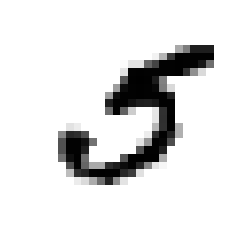

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

The MNIST dataset is actually already split into a training set (the first 60000 images) and a test set (the last 10000 images).

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9668 , 0.96845, 0.9689 ])

In [13]:
# verify not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9111 , 0.90815, 0.9097 ])

### Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54034,   545],
       [ 1372,  4049]])

### Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8813670004353504

In [18]:
recall_score(y_train_5, y_train_pred)

0.7469101641763513

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8085871193210185

### Precision/Recall Tradeoff

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([106258.54690528])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([ -716527.77635209,  -753178.10794578,  -269248.68541135, ...,
        -214503.68155262,  -411344.76036395, -1103134.96827543])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

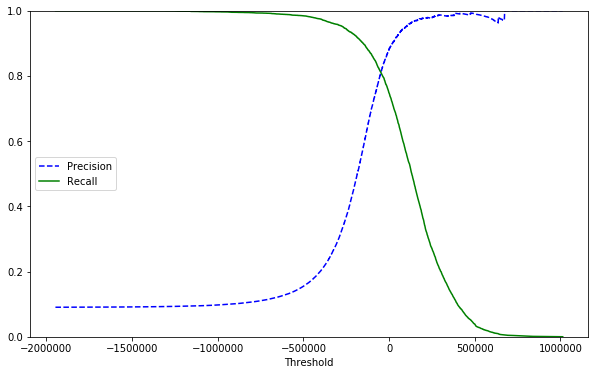

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
y_train_90 = (y_scores > 70000) # 70000 comes from the plot above
precision_score(y_train_5, y_train_90)

0.9377431906614786

In [27]:
recall_score(y_train_5, y_train_90)

0.6223943921785648

### The ROC Curve

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

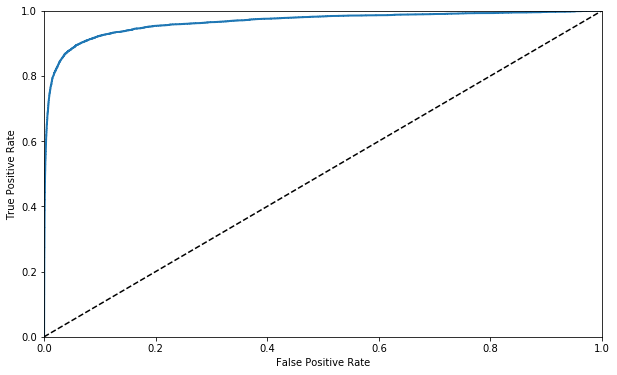

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(10, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9652521880191073

In [31]:
# compare Random Forest and SGD
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [32]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

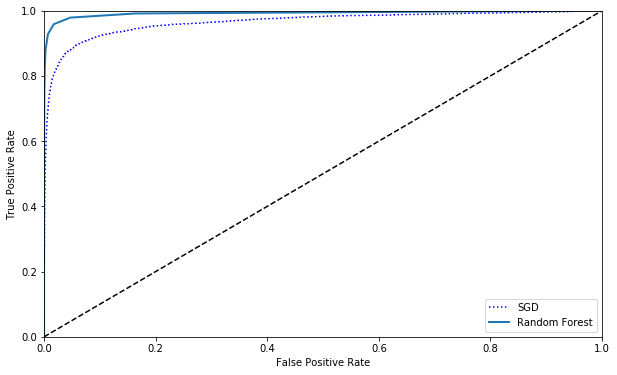

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921156158211916

## Multiclass Classification

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[   2319.10085095, -374924.02656531, -427191.71407596,
        -178787.00106024, -394497.32973737,  106258.54690528,
        -616660.3970818 , -332754.30368838, -521595.70512451,
        -717803.1919061 ]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
sgd_clf.classes_[5]

5.0

In [40]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85177964, 0.87089354, 0.87173076])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85177964, 0.87089354, 0.87173076])

## Error Analysis

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    3,   24,   12,   11,   45,   42,    9,   39,    4],
       [   2, 6460,   42,   26,    6,   43,    7,    8,  135,   13],
       [  52,   37, 5351,   93,   83,   28,   76,   60,  165,   13],
       [  45,   36,  133, 5363,    3,  224,   37,   53,  139,   98],
       [  22,   28,   37,    7, 5359,    8,   47,   29,   83,  222],
       [  77,   38,   36,  186,   69, 4595,  107,   27,  170,  116],
       [  34,   22,   47,    2,   45,  102, 5613,    7,   46,    0],
       [  26,   20,   70,   26,   55,   10,    6, 5788,   15,  249],
       [  50,  137,   71,  154,   15,  156,   54,   28, 5052,  134],
       [  41,   29,   26,   92,  154,   35,    2,  188,   74, 5308]])

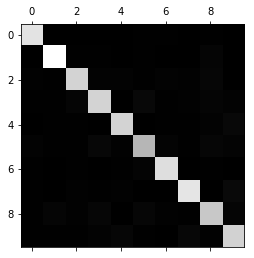

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

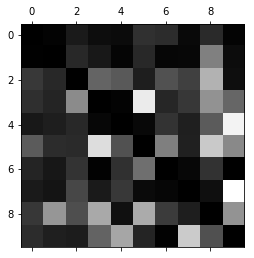

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

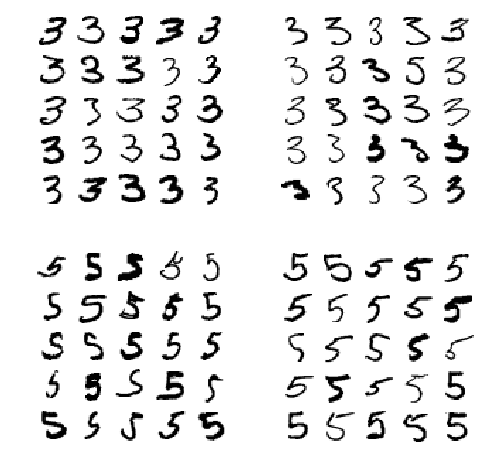

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()